# **SP500 Real-time Forecasting**

In [ ]:
# comment out and install if not already installed
!pip install nixtla
!pip install pandas_datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.0 MB/s eta 0:00:00


## Data Exploration

In [ ]:
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

# Set the start and end dates for the data you want to fetch
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2025, 2,22)

# Replace 'your_api_key' with your actual FRED API key
data_api_key = 'f991b096176052102274fd6f4bbfef0e'

# Fetch S&P 500 data from FRED
sp500 = web.DataReader('SP500', 'fred', start, end)

# Display the most recent data
sp500 = sp500.reset_index()  # Reset index to have 'date' as a column
sp500


,DATE,SP500
0,2016-01-01,NaN
1,2016-01-04,2012.66
2,2016-01-05,2016.71
3,2016-01-06,1990.26
4,2016-01-07,1943.09
...,...,...
2381,2025-02-17,NaN
2382,2025-02-18,6129.58
2383,2025-02-19,6144.15
2384,2025-02-20,6117.52


In [ ]:
len(sp500)

2386

In [ ]:
sp500.isnull().sum()

,0
DATE,0
SP500,88


SP500 dataset is updated daily but has some null values.

In [ ]:
# Fetch GDP data from FRED
gdp = web.DataReader('GDP', 'fred', start, end, api_key=data_api_key)
# Make sure the GDP data is aligned with the S&P 500 data (using 'timestamp')
gdp = gdp.reset_index()  # Reset index to make 'date' a column
gdp = gdp.rename(columns={'DATE': 'DATE', 'GDP': 'GDP'})

gdp.head()

,DATE,GDP
0,2016-01-01,18525.933
1,2016-04-01,18711.702
2,2016-07-01,18892.639
3,2016-10-01,19089.379
4,2017-01-01,19280.084


In [ ]:
len(gdp)

100

In [ ]:
gdp.isnull().sum()

,0
GDP,0


While gdp doesn't have any null values, it is updated only once a month.

## Data Preprocessing

Approach:

1. Monthly, three-monthly data: Used the merge_asof()
 function to fill in missing data with the nearest available values.

2. Data that originally has na: Applied interpolate(method='linear') to estimate missing values by linearly interpolating between known data points, ensuring a smooth progression in the dataset.

In [ ]:
from nixtla import NixtlaClient
api_key = 'nixak-S4pOCBGx86tm0CzCBF8Z1LGMstPXwnQ3u8o6IvlWkebsIsrLLIjrRuA8LeJ1g8kmaL0bxF0rGtYw8MHl'
nixtla_client = NixtlaClient(api_key = api_key)


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import pandas as pd
import pandas_datareader.data as web
import datetime
from sklearn.model_selection import train_test_split

# Set the start and end date for data collection
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# Fetch data from FRED (S&P 500, Unemployment Rate, GDP, CPI, etc.)
data_api_key = 'f991b096176052102274fd6f4bbfef0e'

sp500 = web.DataReader('SP500', 'fred', start, end, api_key=data_api_key)
unemployment = web.DataReader('UNRATE', 'fred', start, end, api_key=data_api_key) #updated once in three months
gdp = web.DataReader('GDP', 'fred', start, end, api_key=data_api_key) #updated once in three months
cpi = web.DataReader('CPIAUCSL', 'fred', start, end, api_key=data_api_key) #updated once in a month
interest_rate = web.DataReader('FEDFUNDS', 'fred', start, end, api_key=data_api_key) #updated once in a month
industrial_production = web.DataReader('INDPRO', 'fred', start, end, api_key=data_api_key) #updated once in a month
retail_sales = web.DataReader('RSXFS', 'fred', start, end, api_key=data_api_key) #updated once in a month

# Merge all data into one dataframe
df = pd.merge_asof(sp500.sort_values('DATE'), unemployment.sort_values('DATE'), on='DATE')
df = pd.merge_asof(df.sort_values('DATE'), gdp.sort_values('DATE'), on='DATE')
df = pd.merge_asof(df.sort_values('DATE'), cpi.sort_values('DATE'), on='DATE')
df = pd.merge_asof(df.sort_values('DATE'), interest_rate.sort_values('DATE'), on='DATE')
df = pd.merge_asof(df.sort_values('DATE'), industrial_production.sort_values('DATE'), on='DATE')
df = pd.merge_asof(df.sort_values('DATE'), retail_sales.sort_values('DATE'), on='DATE')

# Clean and interpolate missing values
df_cleaned = df.interpolate(method='linear')

# Display the cleaned data
df_cleaned


,DATE,SP500,UNRATE,GDP,CPIAUCSL,FEDFUNDS,INDPRO,RSXFS
0,2015-02-23,2109.660,5.5,18063.529,235.342,0.11,102.1366,384779
1,2015-02-24,2115.480,5.5,18063.529,235.342,0.11,102.1366,384779
2,2015-02-25,2113.860,5.5,18063.529,235.342,0.11,102.1366,384779
3,2015-02-26,2110.740,5.5,18063.529,235.342,0.11,102.1366,384779
4,2015-02-27,2104.500,5.5,18063.529,235.342,0.11,102.1366,384779
...,...,...,...,...,...,...,...,...
2605,2025-02-17,6122.105,4.0,29700.580,319.086,4.33,103.5110,625280
2606,2025-02-18,6129.580,4.0,29700.580,319.086,4.33,103.5110,625280
2607,2025-02-19,6144.150,4.0,29700.580,319.086,4.33,103.5110,625280
2608,2025-02-20,6117.520,4.0,29700.580,319.086,4.33,103.5110,625280


In [ ]:
df.isnull().sum()

,0
DATE,0
SP500,94
UNRATE,0
GDP,0
CPIAUCSL,0
FEDFUNDS,0
INDPRO,0
RSXFS,0


In [ ]:
df_cleaned.isnull().sum()

,0
DATE,0
SP500,0
UNRATE,0
GDP,0
CPIAUCSL,0
FEDFUNDS,0
INDPRO,0
RSXFS,0


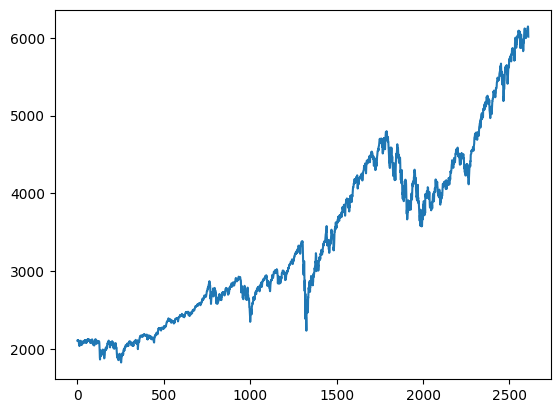

In [ ]:
plt.plot(df_cleaned["SP500"])

## Model Development

### Data Splitting

I chose 95%/5% split since forecasting is done in a relatively short term (a month ~ a few month).

In [ ]:
# Define the train-test split date
train_size = int(len(df_cleaned)*.95)  # 95% for training, latest 5 % for testing

train_data = df_cleaned[:train_size]
test_data = df_cleaned[train_size:]

# Separate the features (X) and target (y) columns
X_train = train_data.drop(columns=['SP500'])
y_train = train_data['SP500']

X_test = test_data.drop(columns=['SP500'])
y_test = test_data['SP500']

# Display the split data
print(f'Training data shape: {X_train.shape}, Test data shape: {X_test.shape}')

Training data shape: (2479, 7), Test data shape: (131, 7)


### Transfer Learning / Fine-tuning

We tried various finetune depth and loss function to see what works the best.

In [ ]:
depths = [1, 2, 3, 4, 5]

test_data = test_data.copy()

for depth in depths:
    preds_df = nixtla_client.forecast(
      df=train_data,
      h=len(test_data),
      finetune_steps=5,
      finetune_depth=depth,
      time_col='DATE',
      target_col='SP500')

    preds = preds_df['TimeGPT'].values

    test_data.loc[:,f'TimeGPT_depth{depth}'] = preds

/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarnin

In [ ]:
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

test_data['unique_id'] = 0

evaluation = evaluate(test_data, metrics=[mae, mse], time_col="DATE", target_col="SP500")
evaluation
#depth 3 got the best result

,unique_id,metric,UNRATE,GDP,CPIAUCSL,FEDFUNDS,INDPRO,RSXFS,TimeGPT_depth1,TimeGPT_depth2,TimeGPT_depth3,TimeGPT_depth4,TimeGPT_depth5
0,0,mae,5.876339e+03,2.375303e+04,5.563540e+03,5.875764e+03,5.777669e+03,6.192992e+05,194.812333,192.942757,142.783099,151.624862,207.900968
1,0,mse,3.456205e+07,5.642193e+08,3.098320e+07,3.455538e+07,3.341206e+07,3.835504e+11,53206.120043,52400.494801,30051.422846,33688.454888,59853.324769


In [ ]:
loss_functions = ["mae", "mse", "rmse", "mape", "smape"]

test_data = test_data.copy()

for loss_function in loss_functions:
    preds_df = nixtla_client.forecast(
      df=train_data,
      h=len(test_data),
      finetune_steps=5,
      finetune_loss=loss_function,
      finetune_depth=3,
      time_col='DATE',
      target_col='SP500')

    preds = preds_df['TimeGPT'].values

    test_data.loc[:,f'{loss_function}'] = preds

/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarnin

In [ ]:
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

test_data['unique_id'] = 0

evaluation = evaluate(test_data, metrics=[mae, mse], time_col="DATE", target_col="SP500")
evaluation
#depth smape got the best result

,unique_id,metric,UNRATE,GDP,CPIAUCSL,FEDFUNDS,INDPRO,RSXFS,TimeGPT_depth1,TimeGPT_depth2,TimeGPT_depth3,TimeGPT_depth4,TimeGPT_depth5,mae,mse,rmse,mape,smape
0,0,mae,5.876339e+03,2.375303e+04,5.563540e+03,5.875764e+03,5.777669e+03,6.192992e+05,194.812333,192.942757,142.783099,151.624862,207.900968,150.672251,225.947887,226.216784,389.103543,111.981331
1,0,mse,3.456205e+07,5.642193e+08,3.098320e+07,3.455538e+07,3.341206e+07,3.835504e+11,53206.120043,52400.494801,30051.422846,33688.454888,59853.324769,33122.833586,69633.270594,69778.081362,183006.913188,18718.368681


The model with a depth of 3 and evaluation using SMAPE (Symmetric Mean Absolute Percentage Error) achieved the best performance.

## Model Evaluation

In [ ]:
# Forecast using Nixtla
fcst_train = nixtla_client.forecast(df=train_data, h=len(test_data), finetune_depth=3, finetune_loss="smape", time_col='DATE', target_col='SP500',finetune_steps=15)
fcst_train.rename(columns={'TimeGPT':'SP500'}, inplace=True)
# Display the forecasted values
fcst_train

/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(


,DATE,SP500
0,2024-08-23,5618.8867
1,2024-08-26,5641.3650
2,2024-08-27,5651.1100
3,2024-08-28,5652.9150
4,2024-08-29,5682.3193
...,...,...
126,2025-02-17,5961.9497
127,2025-02-18,6013.6304
128,2025-02-19,6018.5890
129,2025-02-20,6015.9180


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


# Evaluate the forecast performance
mae = mean_absolute_error(test_data['SP500'], fcst_train['SP500'])
rmse = np.sqrt(mean_squared_error(test_data['SP500'], fcst_train['SP500']))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 89.48889999999999
RMSE: 107.42383364220014


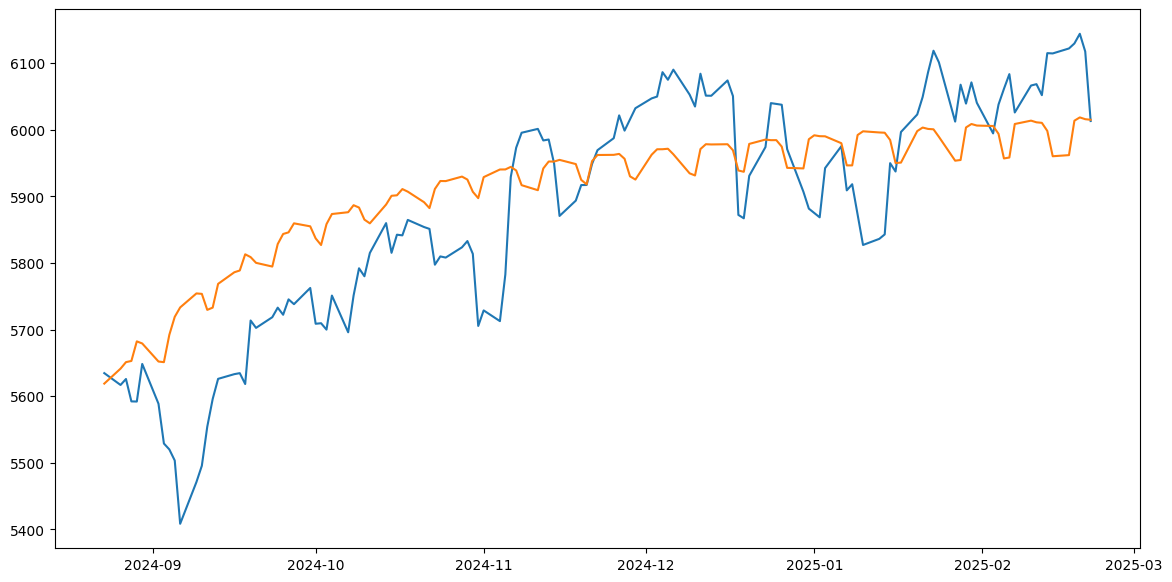

In [ ]:
import matplotlib. pyplot as plt
y_test
#fcst_train
plt.figure(figsize=(14, 7))
plt.plot(test_data['DATE'], test_data['SP500'])
plt.plot(fcst_train['DATE'], fcst_train['SP500'])

## Predicting only a month of SP500 values

Since the prediction relys on values such as GDP that are updated monthly, we also tried predicting only one month of SP500.

In [ ]:
# Define the train-test split date (e.g., using the last 20% of data for testing)
train_size = int(len(df_cleaned)-30)  # 95% for training

train_data = df_cleaned[:train_size]
test_data = df_cleaned[train_size:]

# Separate the features (X) and target (y) columns
X_train = train_data.drop(columns=['SP500'])
y_train = train_data['SP500']

X_test = test_data.drop(columns=['SP500'])
y_test = test_data['SP500']

depths = [1, 2, 3, 4, 5]

test_data = test_data.copy()

for depth in depths:
    preds_df = nixtla_client.forecast(
      df=train_data,
      h=len(test_data),
      finetune_steps=5,
      finetune_depth=depth,
      time_col='DATE',
      target_col='SP500')

    preds = preds_df['TimeGPT'].values

    test_data.loc[:,f'TimeGPT_depth{depth}'] = preds

from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

test_data['unique_id'] = 0

evaluation = evaluate(test_data, metrics=[mae, mse], time_col="DATE", target_col="SP500")
evaluation


/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarnin

,unique_id,metric,UNRATE,GDP,CPIAUCSL,FEDFUNDS,INDPRO,RSXFS,TimeGPT_depth1,TimeGPT_depth2,TimeGPT_depth3,TimeGPT_depth4,TimeGPT_depth5
0,0,mae,6.039971e+03,2.365661e+04,5.724885e+03,6.039641e+03,5.940460e+03,6.192360e+05,134.525327,136.409057,150.869460,158.283147,163.525313
1,0,mse,3.648676e+07,5.596407e+08,3.277981e+07,3.648277e+07,3.529457e+07,3.834533e+11,21419.751290,21952.033953,26241.458551,28646.363870,30466.758001


In [ ]:
loss_functions = ["mae", "mse", "rmse", "mape", "smape"]

test_data = test_data.copy()

for loss_function in loss_functions:
    preds_df = nixtla_client.forecast(
      df=train_data,
      h=len(test_data),
      finetune_steps=5,
      finetune_loss=loss_function,
      finetune_depth=1,
      time_col='DATE',
      target_col='SP500')

    preds = preds_df['TimeGPT'].values

    test_data.loc[:,f'{loss_function}'] = preds
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

test_data['unique_id'] = 0

evaluation = evaluate(test_data, metrics=[mae, mse], time_col="DATE", target_col="SP500")
evaluation

/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarnin

,unique_id,metric,UNRATE,GDP,CPIAUCSL,FEDFUNDS,INDPRO,RSXFS,TimeGPT_depth1,TimeGPT_depth2,TimeGPT_depth3,TimeGPT_depth4,TimeGPT_depth5,mae,mse,rmse,mape,smape
0,0,mae,6.039971e+03,2.365661e+04,5.724885e+03,6.039641e+03,5.940460e+03,6.192360e+05,134.525327,136.409057,150.869460,158.283147,163.525313,132.625923,145.154093,144.876647,151.307210,141.44294
1,0,mse,3.648676e+07,5.596407e+08,3.277981e+07,3.648277e+07,3.529457e+07,3.834533e+11,21419.751290,21952.033953,26241.458551,28646.363870,30466.758001,20917.499653,24562.043270,24477.123695,26637.362131,23601.89971


In [ ]:
from nixtla import NixtlaClient
api_key = 'nixak-S4pOCBGx86tm0CzCBF8Z1LGMstPXwnQ3u8o6IvlWkebsIsrLLIjrRuA8LeJ1g8kmaL0bxF0rGtYw8MHl'
nixtla_client = NixtlaClient(api_key = api_key)
# Forecast using Nixtla
sp500_prediction = nixtla_client.forecast(df=train_data, h=30, finetune_depth=1, finetune_loss="mae", time_col='DATE', target_col='SP500',finetune_steps=15)
sp500_prediction.rename(columns={'TimeGPT':'SP500'}, inplace=True)

/usr/local/lib/python3.11/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['UNRATE', 'GDP', 'CPIAUCSL', 'FEDFUNDS', 'INDPRO', 'RSXFS'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(


In this configuration, the model with a depth of 1 and evaluation using MAE (Mean Absolute Error) achieved the best performance.

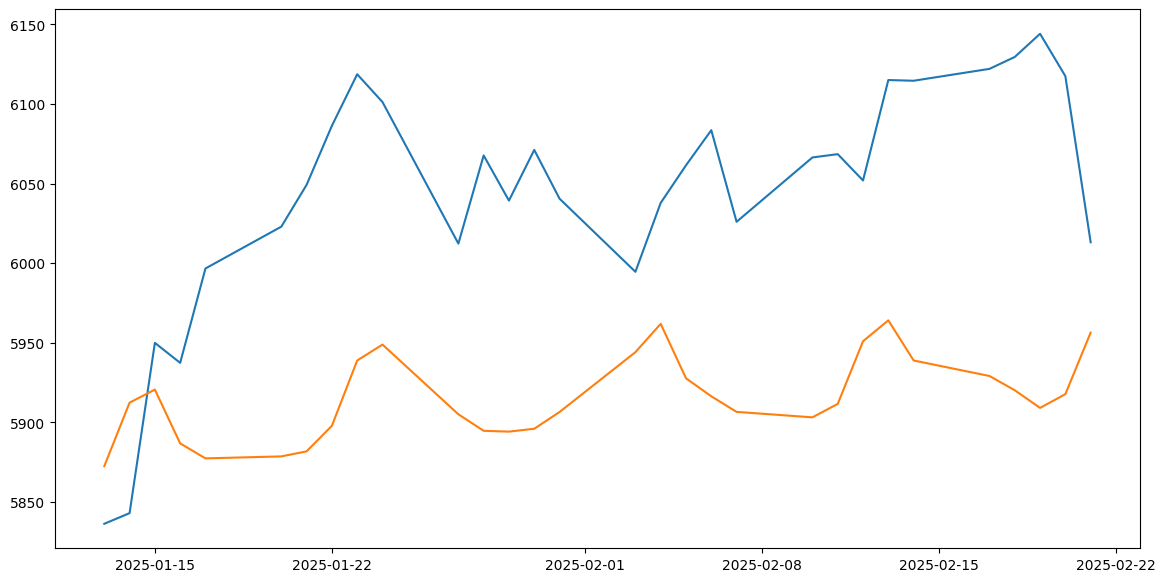

In [ ]:
import matplotlib. pyplot as plt
y_test
#fcst_train
plt.figure(figsize=(14, 7))
plt.plot(test_data['DATE'], test_data['SP500'])
plt.plot(sp500_prediction['DATE'], sp500_prediction['SP500'])